### Notebook 4 of Capstone Project: Modelling Using Recurrent Neural Networks!

Import the needed libraries here:

In [1]:
#the standard usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#keras imports
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from keras.layers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [2]:
data = pd.read_csv('oil_and_gas_data/data_for_modelling/data_ready_for_modelling.csv', index_col=0)
data.head()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-01,0.0,0.0,0,NaN,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502
2016-01-02,0.0,0.0,0,0.0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861
2016-01-03,0.0,0.0,0,0.0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135
2016-01-04,0.0,0.0,0,0.0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281
2016-01-05,0.0,0.0,0,0.0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281


In [3]:
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1859 entries, 2016-01-01 to 2021-02-01
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Daily_Avg          1859 non-null   float64
 1   Daily_Sum          1859 non-null   float64
 2   Daily_Count        1859 non-null   int64  
 3   Dly_Cnt_Diff       1858 non-null   float64
 4   Rig_Count          1760 non-null   float64
 5   WTI_Spot_Price     1859 non-null   float64
 6   Brent_Spot_Price   1859 non-null   float64
 7   fracs_per_day      1801 non-null   float64
 8   volume_per_day     1801 non-null   float64
 9   avg_volh2o_per_ft  1695 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 159.8 KB


The first model I want to try will be a classification problem where I try to predict if the daily seismicity goes up or down (I'm going to lump staying the same with going down). I'm also going to start with just one feature, the fracs per day column, and then build from there.

In [4]:
#drop the Nan's from the data
data_model = data.dropna()
data_model.head()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-02,0.0,0.0,0,0.0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861
2016-01-03,0.0,0.0,0,0.0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135
2016-01-04,0.0,0.0,0,0.0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281
2016-01-05,0.0,0.0,0,0.0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281
2016-01-06,0.0,0.0,0,0.0,33.0,33.97,33.89,26.0,1.195583e+07,813.047953


In [5]:
#define our X and y
X = data_model[['fracs_per_day']]
y = np.where(data_model['Dly_Cnt_Diff'] > 0, 1, 0)

In [6]:
data_model['Dly_Cnt_Diff'].value_counts()

 0.0     1410
-1.0       71
 1.0       58
 2.0       22
-2.0       20
-3.0        7
 5.0        5
 3.0        4
 4.0        4
-4.0        3
-5.0        1
-24.0       1
 12.0       1
 11.0       1
 6.0        1
-6.0        1
Name: Dly_Cnt_Diff, dtype: int64

We definitely have an inbalanced class issue here. For the way I've lumped the target column, I have 1515 0's and 96 1's, which is a 94%/6% ratio. That's not good. Let's just run this model to get our feet wet and see how it goes. We can run a different model next. 

In [7]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [8]:
X_train.head()

,fracs_per_day
2016-01-02,11.0
2016-01-03,9.0
2016-01-04,26.0
2016-01-05,26.0
2016-01-06,26.0


In [9]:
#now need to scale the data
sscaler = StandardScaler()

In [10]:
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [11]:
X_train_sc.shape

(1207, 1)

In [12]:
#we have quite a bit of data in here, we'll need to make sure we generate stacks of this data

In [13]:
#break up the data into 7-day stacks
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)

In [14]:
batch_x, batch_y = train_sequences[0]

In [15]:
batch_x[:3]

array([[[-0.44622721],
        [-0.59640043],
        [ 0.68007192],
        [ 0.68007192],
        [ 0.68007192],
        [ 0.75515852],
        [ 0.75515852]],

       [[-0.59640043],
        [ 0.68007192],
        [ 0.68007192],
        [ 0.68007192],
        [ 0.75515852],
        [ 0.75515852],
        [ 0.75515852]],

       [[ 0.68007192],
        [ 0.68007192],
        [ 0.68007192],
        [ 0.75515852],
        [ 0.75515852],
        [ 0.75515852],
        [ 0.75515852]]])

In [16]:
batch_y[:3]

array([0, 0, 0])

In [17]:
batch_x.shape

(64, 7, 1)

In [18]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [19]:
#I'm going to use a simple RNN to start
model1 = Sequential()
model1.add(SimpleRNN(8, input_shape = (7,1)))
model1.add(Dense(20, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

In [20]:
model1.compile(loss='bce', optimizer = 'adam', metrics=['acc'])

In [21]:
history1 = model1.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

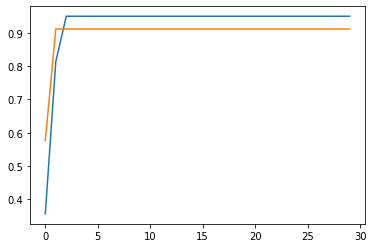

In [22]:
#this ran quick, so that is nice. let's look at our accuracy
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])

Well, we had really unbalanced classes going into this thing, so I didn't expect to get great results. Let me now switch to a regression problem instead, using the same target (but not lumped), and see how that does.

In [23]:
#I'll redefine X and y here
#x is the same
X = data_model[['fracs_per_day']]
#y will just be the Dly_Cnt_Diff column
y = data_model['Dly_Cnt_Diff']

In [24]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [25]:
#now need to scale the data
sscaler = StandardScaler()

In [26]:
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [27]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [28]:
X_train_sc.shape

(1207, 1)

In [29]:
batch_x, batch_y = train_sequences[0]

In [30]:
batch_x[:1]

array([[[-0.44622721],
        [-0.59640043],
        [ 0.68007192],
        [ 0.68007192],
        [ 0.68007192],
        [ 0.75515852],
        [ 0.75515852]]])

In [31]:
batch_y[:1]

array([0.])

In [32]:
batch_x.shape

(64, 7, 1)

In [33]:
#I'm going to use a simple RNN to start
model2 = Sequential()
model2.add(SimpleRNN(8, input_shape = (7,1)))
model2.add(Dense(20, activation = 'relu'))
model2.add(Dense(1))

In [34]:
model2.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])

In [35]:
history2 = model2.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

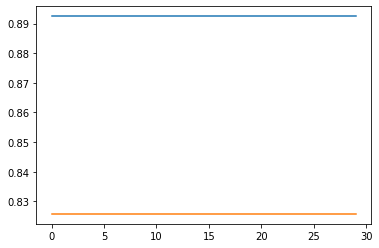

In [36]:
#let's look at our accuracy
plt.plot(history2.history['acc'], label='accuracy')
plt.plot(history2.history['val_acc'], label = 'val_accuracy')

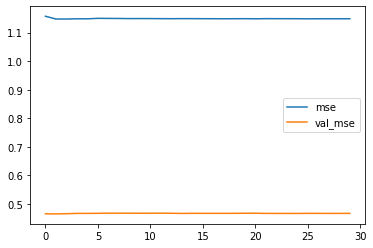

In [37]:
#let's look at our loss/mse
plt.plot(history2.history['mse'], label='mse')
plt.plot(history2.history['val_mse'], label='val_mse')
plt.legend();

This is doing about as good as our simple mean rmse that we ran prior to doing the ARIMA model. Recall that our rmse using the simple mean was 0.4. So, we'll keep going and try to get a better result with different model architecture.

In [38]:
#I'm going to use a GRU now to see if this makes any difference
model3 = Sequential()
model3.add(GRU(8, input_shape = (7,1)))
model3.add(Dense(20, activation = 'relu'))
model3.add(Dense(1))

model3.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history3 = model3.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

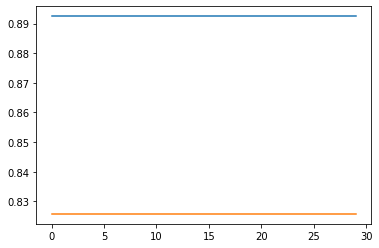

In [39]:
#let's look at our accuracy
plt.plot(history3.history['acc'], label='accuracy')
plt.plot(history3.history['val_acc'], label = 'val_accuracy')

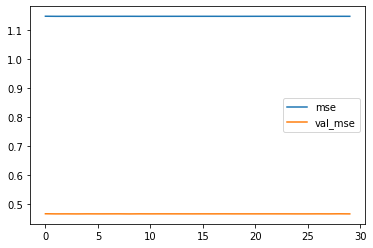

In [40]:
#let's look at our loss/mse
plt.plot(history3.history['mse'], label='mse')
plt.plot(history3.history['val_mse'], label='val_mse')
plt.legend();

In [41]:
#it did about the same; let's make the model more complicated
#I'm going to use multiple GRUs now to see if this makes any difference
model4 = Sequential()
model4.add(GRU(8, input_shape = (7,1), return_sequences=True))
model4.add(GRU(8, return_sequences=True))
model4.add(GRU(8))
model4.add(Dense(20, activation = 'relu'))
model4.add(Dense(1))

model4.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history4 = model4.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

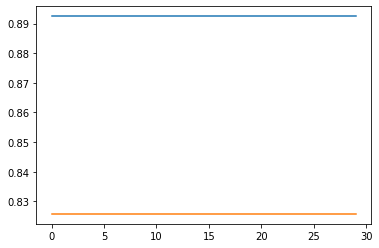

In [42]:
#let's look at our accuracy
plt.plot(history4.history['acc'], label='accuracy')
plt.plot(history4.history['val_acc'], label = 'val_accuracy')

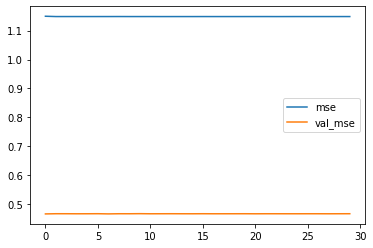

In [43]:
#let's look at our loss/mse
plt.plot(history4.history['mse'], label='mse')
plt.plot(history4.history['val_mse'], label='val_mse')
plt.legend();

In [44]:
#it did the same; let's make the model more complicated
#I'm going to use a GRU with dropout now to see if this makes any difference
model5 = Sequential()
model5.add(GRU(8, input_shape = (7,1), return_sequences=True))
model5.add(GRU(8, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model5.add(GRU(8))
model5.add(Dense(20, activation = 'relu'))
model5.add(Dense(1))

model5.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history5 = model5.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

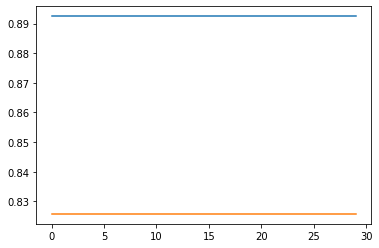

In [45]:
#let's look at our accuracy
plt.plot(history5.history['acc'], label='accuracy')
plt.plot(history5.history['val_acc'], label = 'val_accuracy')

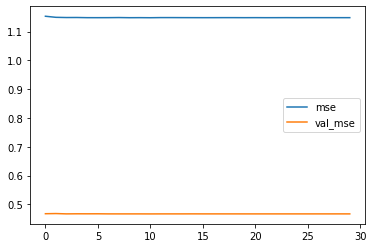

In [46]:
#let's look at our loss/mse
plt.plot(history5.history['mse'], label='mse')
plt.plot(history5.history['val_mse'], label='val_mse')
plt.legend();

In [47]:
#it did the same; let's make the model more complicated
#I'm going to use a GRU with dropout now to see if this makes any difference
model6 = Sequential()
model6.add(Bidirectional(GRU(8, input_shape = (7,1), return_sequences=True)))
model6.add(GRU(8, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model6.add(GRU(8))
model6.add(Dense(20, activation = 'relu'))
model6.add(Dense(1))

model6.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history6 = model6.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

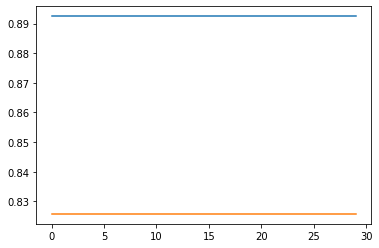

In [48]:
#let's look at our accuracy
plt.plot(history6.history['acc'], label='accuracy')
plt.plot(history6.history['val_acc'], label = 'val_accuracy')

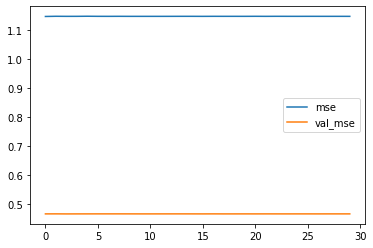

In [49]:
#let's look at our loss/mse
plt.plot(history6.history['mse'], label='mse')
plt.plot(history6.history['val_mse'], label='val_mse')
plt.legend();

In [50]:
#it did the same; let's make the model more complicated
#I'm going to use an LSTM now with dropout to see if this makes any difference
model7 = Sequential()
model7.add(Bidirectional(LSTM(8, input_shape = (7,1), return_sequences=True)))
model7.add(LSTM(8, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model7.add(LSTM(8))
model7.add(Dense(20, activation = 'relu'))
model7.add(Dense(1))

model7.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history7 = model7.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

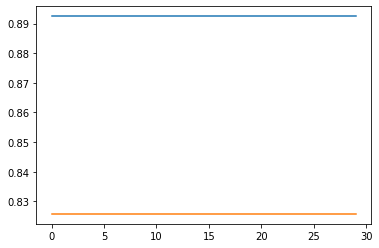

In [51]:
#let's look at our accuracy
plt.plot(history7.history['acc'], label='accuracy')
plt.plot(history7.history['val_acc'], label = 'val_accuracy')

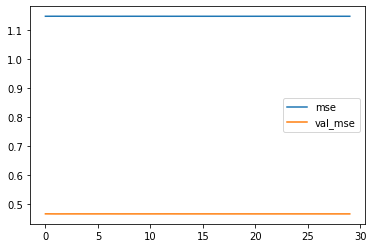

In [52]:
#let's look at our loss/mse
plt.plot(history7.history['mse'], label='mse')
plt.plot(history7.history['val_mse'], label='val_mse')
plt.legend();

I'm going to try testing a few different features now with a basic model and see if I get anything different.

In [54]:
X = data_model[['Rig_Count', 'WTI_Spot_Price', 'volume_per_day', 'avg_volh2o_per_ft']]
#y will be the same
y = data_model['Dly_Cnt_Diff']

In [55]:
#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [56]:
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [57]:
#break up the data into 3-day stacks
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)

In [58]:
batch_x, batch_y = train_sequences[0]

In [59]:
batch_x[:3]

array([[[ 0.85265453, -1.58644214, -0.79573962, -1.7798988 ],
        [ 0.85265453, -1.58644214, -0.929386  , -1.63081953],
        [ 0.85265453, -1.61728604, -0.25686165, -2.14269738]],

       [[ 0.85265453, -1.58644214, -0.929386  , -1.63081953],
        [ 0.85265453, -1.61728604, -0.25686165, -2.14269738],
        [ 0.85265453, -1.69825128, -0.25686165, -2.14269738]],

       [[ 0.85265453, -1.61728604, -0.25686165, -2.14269738],
        [ 0.85265453, -1.69825128, -0.25686165, -2.14269738],
        [ 0.85265453, -1.89102566, -0.19705072, -2.20739147]]])

In [60]:
batch_x.shape

(64, 3, 4)

In [61]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

In [62]:
#I'm going to use multiple GRUs
model9 = Sequential()
model9.add(GRU(8, input_shape = (3,4), return_sequences=True))
model9.add(GRU(8, return_sequences=True))
model9.add(GRU(8))
model9.add(Dense(20, activation = 'relu'))
model9.add(Dense(1))

model9.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history9 = model9.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

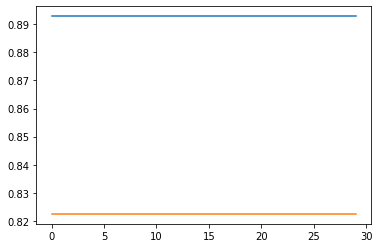

In [63]:
#let's look at our accuracy
plt.plot(history9.history['acc'], label='accuracy')
plt.plot(history9.history['val_acc'], label = 'val_accuracy')

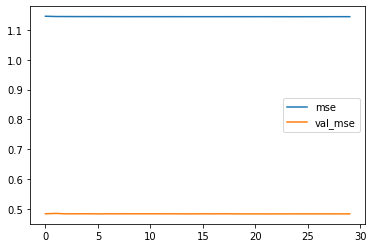

In [64]:
#let's look at our loss/mse
plt.plot(history9.history['mse'], label='mse')
plt.plot(history9.history['val_mse'], label='val_mse')
plt.legend();

Okay, this did the same. I'm going to try using a different target now. Same X features.

In [65]:
X = data_model[['Rig_Count', 'WTI_Spot_Price', 'volume_per_day', 'avg_volh2o_per_ft']]
#y will be the daily_sum column
y = data_model['Daily_Sum']

In [66]:
#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [67]:
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [68]:
#break up the data into 3-day stacks
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)

In [69]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 3, 4)

In [70]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

In [71]:
#I'm going to use multiple GRUs
model10 = Sequential()
model10.add(GRU(8, input_shape = (3,4), return_sequences=True))
model10.add(GRU(20, return_sequences=True))
model10.add(GRU(10))
model10.add(Dense(20, activation = 'relu'))
model10.add(Dense(1))

model10.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history10 = model10.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

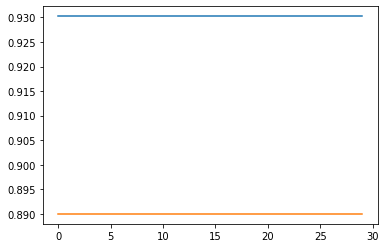

In [72]:
#let's look at our accuracy
plt.plot(history10.history['acc'], label='accuracy')
plt.plot(history10.history['val_acc'], label = 'val_accuracy')

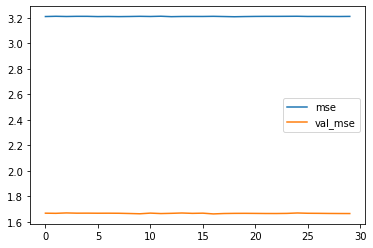

In [73]:
#let's look at our loss/mse
plt.plot(history10.history['mse'], label='mse')
plt.plot(history10.history['val_mse'], label='val_mse')
plt.legend();

In [74]:
#let me make a quick baseline model so we can assess how this model did
mean_y_train_array = np.full_like(y_train, y_train.mean())
mean_y_train_array

array([0.3054681, 0.3054681, 0.3054681, ..., 0.3054681, 0.3054681,
       0.3054681])

In [75]:
mean_squared_error(y_train, mean_y_train_array, squared=False)

1.7632969586758556

In [76]:
mean_y_test_array = np.full_like(y_test, y_test.mean())

In [77]:
mean_squared_error(y_test, mean_y_test_array, squared=False)

1.2378104935320362

This did worse than a simple mean model. I'm going to try a smaller time range and see how that does.

In [78]:
data_small = data_model.loc['10-1-2017':'3-31-2020',]

In [79]:
data_small

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2017-10-01,0.0,0.0,0,0.0,27.0,51.67,57.02,47.0,2.651121e+07,2057.055001
2017-10-02,0.0,0.0,0,0.0,27.0,50.59,55.67,46.0,2.490001e+07,2055.337718
2017-10-03,0.0,0.0,0,0.0,27.0,50.44,56.12,46.0,2.490001e+07,2055.337718
2017-10-04,0.0,0.0,0,0.0,27.0,50.00,56.00,23.0,1.212874e+07,1868.106876
2017-10-05,0.0,0.0,0,0.0,27.0,50.79,57.09,19.0,1.072558e+07,1911.134559
...,...,...,...,...,...,...,...,...,...,...
2020-03-27,0.0,0.0,0,-1.0,33.0,15.48,22.39,33.0,1.874334e+07,2329.799570
2020-03-28,0.0,0.0,0,0.0,30.0,15.48,22.39,33.0,1.874334e+07,2329.799570
2020-03-29,0.0,0.0,0,0.0,30.0,15.48,22.39,33.0,1.874334e+07,2329.799570
2020-03-30,0.0,0.0,0,0.0,30.0,14.10,19.19,33.0,1.874334e+07,2329.799570


In [81]:
X = data_small[['Rig_Count', 'WTI_Spot_Price', 'volume_per_day', 'avg_volh2o_per_ft']]
#y will be the daily_sum column
y = data_small['Daily_Sum']

In [82]:
#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [83]:
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [84]:
#break up the data into 3-day stacks
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)

In [85]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 3, 4)

In [86]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

In [87]:
#I'm going to use multiple GRUs
model11 = Sequential()
model11.add(GRU(10, input_shape = (3,4), return_sequences=True))
model11.add(GRU(50, return_sequences=True))
model11.add(GRU(100))
model11.add(Dense(20, activation = 'relu'))
model11.add(Dense(1))

model11.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history11 = model11.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

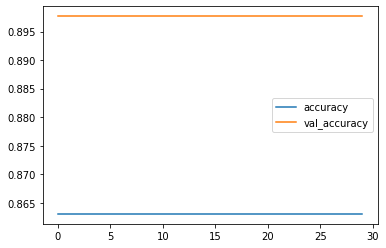

In [88]:
#let's look at our accuracy
plt.plot(history11.history['acc'], label='accuracy')
plt.plot(history11.history['val_acc'], label = 'val_accuracy')
plt.legend();

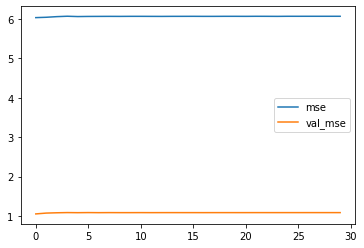

In [89]:
#let's look at our loss/mse
plt.plot(history11.history['mse'], label='mse')
plt.plot(history11.history['val_mse'], label='val_mse')
plt.legend();

In [90]:
#I'm going to use multiple GRUs
model12 = Sequential()
model12.add(GRU(10, input_shape = (3,4), return_sequences=True))
model12.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model12.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model12.add(Dense(20, activation = 'relu'))
model12.add(Dense(1))

model12.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history12 = model12.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

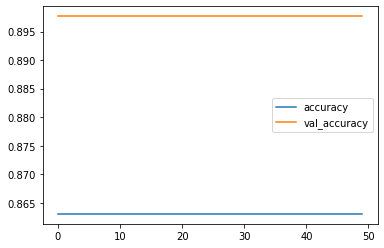

In [91]:
#let's look at our accuracy
plt.plot(history12.history['acc'], label='accuracy')
plt.plot(history12.history['val_acc'], label = 'val_accuracy')
plt.legend();

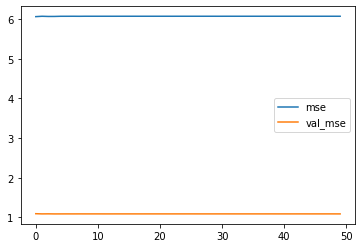

In [92]:
#let's look at our loss/mse
plt.plot(history12.history['mse'], label='mse')
plt.plot(history12.history['val_mse'], label='val_mse')
plt.legend();

What if I resamples to weekly using the smaller time range. I wonder if that would do better.

In [93]:
weekly_data_small = data_small.resample('W').mean()
weekly_data_small

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2017-10-01,0.000000,0.000000,0.000000,0.0,27.000000,51.670000,57.020000,47.000000,2.651121e+07,2057.055001
2017-10-08,0.000000,0.000000,0.000000,0.0,27.571429,49.977143,55.911429,27.142857,1.480486e+07,1940.390559
2017-10-15,0.000000,0.000000,0.000000,0.0,29.857143,50.958571,56.392857,16.142857,9.249819e+06,1928.475138
2017-10-22,0.000000,0.000000,0.000000,0.0,32.285714,51.708571,57.808571,14.714286,7.058174e+06,2132.500242
2017-10-29,0.000000,0.000000,0.000000,0.0,33.857143,52.910000,59.025714,13.142857,6.712036e+06,2241.499288
...,...,...,...,...,...,...,...,...,...,...
2020-03-08,0.000000,0.000000,0.000000,0.0,32.714286,44.307143,49.244286,28.000000,2.196417e+07,2541.374936
2020-03-15,0.000000,0.000000,0.000000,0.0,32.000000,32.195714,33.302857,30.571429,2.360722e+07,2545.060663
2020-03-22,0.000000,0.000000,0.000000,0.0,32.285714,22.847143,25.624286,32.000000,2.262417e+07,2586.057358
2020-03-29,0.271429,0.271429,0.142857,0.0,32.142857,18.307143,23.512857,33.000000,1.900354e+07,2374.692438


In [94]:
X = weekly_data_small[['Rig_Count', 'WTI_Spot_Price', 'volume_per_day', 'avg_volh2o_per_ft']]
#y will be the daily_sum column
y = weekly_data_small['Daily_Sum']

In [95]:
#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [96]:
#make a baseline model to compare against
mean_y_train_array = np.full_like(y_train, y_train.mean())
mean_squared_error(y_train, mean_y_train_array, squared=False)

1.1714938470277203

In [97]:
mean_y_test_array = np.full_like(y_test, y_test.mean())
mean_squared_error(y_test, mean_y_test_array, squared=False)

0.38621267862288555

In [98]:
#now set up the RNN
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [99]:
#break up the data into 3-day stacks
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 3, 4)

In [100]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

In [101]:
#I'm going to use multiple GRUs
model13 = Sequential()
model13.add(GRU(10, input_shape = (3,4), return_sequences=True))
model13.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model13.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model13.add(Dense(20, activation = 'relu'))
model13.add(Dense(1))

model13.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history13 = model13.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

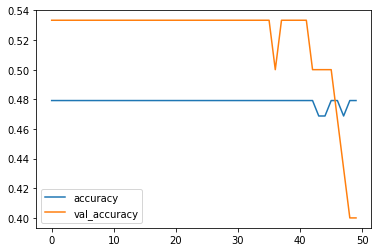

In [102]:
#let's look at our accuracy
plt.plot(history13.history['acc'], label='accuracy')
plt.plot(history13.history['val_acc'], label = 'val_accuracy')
plt.legend();

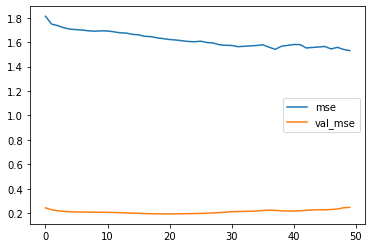

In [103]:
#let's look at our loss/mse
plt.plot(history13.history['mse'], label='mse')
plt.plot(history13.history['val_mse'], label='val_mse')
plt.legend();

In [104]:
#I'm going to use multiple GRUs
model14 = Sequential()
model14.add(GRU(10, input_shape = (3,4), return_sequences=True))
model14.add(GRU(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model14.add(GRU(200, dropout=0.2, recurrent_dropout=0.2))
model14.add(Dense(40, activation = 'relu'))
model14.add(Dense(1))

model14.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history14 = model14.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

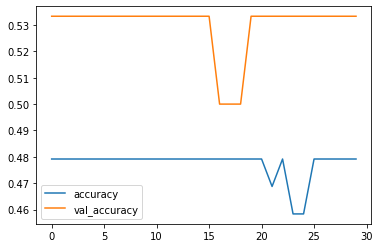

In [105]:
#let's look at our accuracy
plt.plot(history14.history['acc'], label='accuracy')
plt.plot(history14.history['val_acc'], label = 'val_accuracy')
plt.legend();

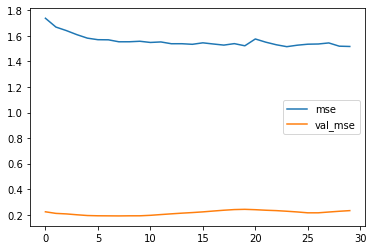

In [106]:
#let's look at our loss/mse
plt.plot(history14.history['mse'], label='mse')
plt.plot(history14.history['val_mse'], label='val_mse')
plt.legend();

check this paper out: https://www.sciencedirect.com/science/article/abs/pii/S0169207018300888

Now I'm going to model the Fasola data and see how that goes.

In [107]:
fasola = pd.read_csv('oil_and_gas_data/data_for_modelling/fasola_data_ready_for_modelling.csv', index_col=0)
fasola.head()

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2016-01-01,0.0,0.0,0,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-02,0.0,0.0,0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-03,0.0,0.0,0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-04,0.0,0.0,0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-05,0.0,0.0,0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."


In [108]:
fasola.index = pd.to_datetime(fasola.index)
fasola.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1859 entries, 2016-01-01 to 2021-02-01
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Daily_Avg          1859 non-null   float64
 1   Daily_Sum          1859 non-null   float64
 2   Daily_Count        1859 non-null   int64  
 3   Rig_Count          1760 non-null   float64
 4   WTI_Spot_Price     1859 non-null   float64
 5   Brent_Spot_Price   1859 non-null   float64
 6   fracs_per_day      1801 non-null   float64
 7   volume_per_day     1801 non-null   float64
 8   avg_volh2o_per_ft  1695 non-null   float64
 9   APIs               1801 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 159.8+ KB


In [109]:
#drop the Nan's from the data
fasola_model = fasola.dropna()
fasola_model.head()

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2016-01-01,0.0,0.0,0,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-02,0.0,0.0,0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-03,0.0,0.0,0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-04,0.0,0.0,0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-05,0.0,0.0,0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."


In [111]:
#I'm going to model a large time range since these models tend to run fast
#the Jan 31, 2020 cutoff is the last meaningful data before COVID started to impact activity
fasola_model = fasola_model.loc['1-1-2017':'1-31-2020']
fasola_model

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2017-01-01,0.000000,0.000000,0,24.0,53.75,54.96,9.0,7.562982e+06,1793.684306,"[42255343990000, 42255344150000, 4225535062000..."
2017-01-02,0.766226,2.298677,3,24.0,53.75,54.96,9.0,7.942106e+06,1721.140972,"[42255343990000, 42255344150000, 4225535062000..."
2017-01-03,0.792245,34.066545,43,24.0,52.36,55.05,9.0,7.942106e+06,1721.140972,"[42255343990000, 42255344150000, 4225535062000..."
2017-01-04,1.025187,10.251870,10,24.0,53.26,54.57,9.0,7.942106e+06,1721.140972,"[42255343990000, 42255344150000, 4225535062000..."
2017-01-05,1.600100,1.600100,1,24.0,53.77,54.99,9.0,7.942106e+06,1721.140972,"[42255343990000, 42255344150000, 4225535062000..."
...,...,...,...,...,...,...,...,...,...,...
2020-01-27,0.000000,0.000000,0,33.0,53.09,58.54,45.0,4.278683e+07,1642.821249,"[42255361860000, 42255361850000, 4225536569000..."
2020-01-28,1.900000,1.900000,1,33.0,53.33,59.37,46.0,4.433917e+07,1658.283946,"[42255361860000, 42255361850000, 4225536569000..."
2020-01-29,0.000000,0.000000,0,33.0,53.29,59.46,44.0,4.293038e+07,1624.508496,"[42255361860000, 42255361850000, 4225536569000..."
2020-01-30,0.000000,0.000000,0,33.0,52.19,57.72,46.0,4.500210e+07,1624.812672,"[42255361860000, 42255361850000, 4225536556000..."


In [112]:
X = fasola_model[['fracs_per_day','volume_per_day','avg_volh2o_per_ft']]
#y will be the daily_sum column
y = fasola_model['Daily_Sum']

In [113]:
#split into train and test data; remember default is 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [122]:
#set up our null model
mean_y_train_array = np.full_like(y_train, y_train.mean())
mean_squared_error(y_train, mean_y_train_array, squared=False)

6.721847536786381

In [123]:
mean_y_test_array = np.full_like(y_test, y_test.mean())
mean_squared_error(y_test, mean_y_test_array, squared=False)

1.3249649424665666

In [114]:
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [115]:
#break up the data into 7-day stacks
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)

In [116]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 3)

In [117]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [119]:
#I'm going to use multiple GRUs
modelf1 = Sequential()
modelf1.add(GRU(10, input_shape = (7,3), return_sequences=True))
modelf1.add(GRU(50, return_sequences=True))
modelf1.add(GRU(100))
modelf1.add(Dense(20, activation = 'relu'))
modelf1.add(Dense(1))

modelf1.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historyf1 = modelf1.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

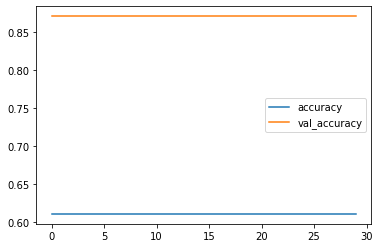

In [120]:
#let's look at our accuracy
plt.plot(historyf1.history['acc'], label='accuracy')
plt.plot(historyf1.history['val_acc'], label = 'val_accuracy')
plt.legend();

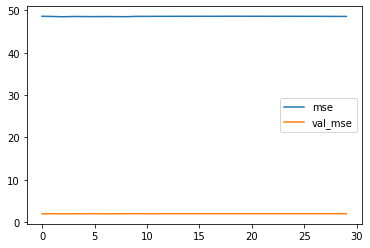

In [121]:
#let's look at our loss/mse
plt.plot(historyf1.history['mse'], label='mse')
plt.plot(historyf1.history['val_mse'], label='val_mse')
plt.legend();

In [124]:
y_train

2017-01-01     0.000000
2017-01-02     2.298677
2017-01-03    34.066545
2017-01-04    10.251870
2017-01-05     1.600100
                ...    
2019-04-11     0.000000
2019-04-12     0.000000
2019-04-20     0.000000
2019-04-21     1.400000
2019-04-22     0.000000
Name: Daily_Sum, Length: 807, dtype: float64

In [125]:
y_test

2019-04-23    0.0
2019-04-24    0.0
2019-04-25    0.0
2019-04-26    0.0
2019-04-27    1.7
             ... 
2020-01-27    0.0
2020-01-28    1.9
2020-01-29    0.0
2020-01-30    0.0
2020-01-31    0.0
Name: Daily_Sum, Length: 270, dtype: float64

I'm going to try one more model, using dropout, to see if I can improve the delta between train and test results.

In [126]:
#I'm going to use dropout with the multiple GRUs
modelf2 = Sequential()
modelf2.add(GRU(10, input_shape = (7,3), return_sequences=True))
modelf2.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelf2.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelf2.add(Dense(20, activation = 'relu'))
modelf2.add(Dense(1))

modelf2.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historyf2 = modelf2.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

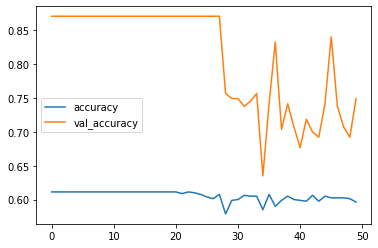

In [127]:
#let's look at our accuracy
plt.plot(historyf2.history['acc'], label='accuracy')
plt.plot(historyf2.history['val_acc'], label = 'val_accuracy')
plt.legend();

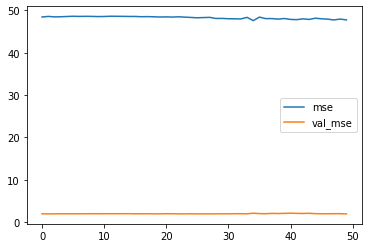

In [128]:
#let's look at our loss/mse
plt.plot(historyf2.history['mse'], label='mse')
plt.plot(historyf2.history['val_mse'], label='val_mse')
plt.legend();

Now I'd like to try one last bit of modelling: I think Daily Average is proving to be the best target to model for, and I want to use the Weekly Average of my largest dataset: all three catalogs that go back to 2012. We'll see how it goes!

In [129]:
mega_df = pd.read_csv('oil_and_gas_data/data_for_modelling/mega_data_ready_for_modelling.csv', index_col=0)

In [130]:
#first thing to do is drop na values
mega_df = mega_df.dropna()
mega_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2863 entries, 2012-03-02 to 2020-12-05
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Daily_Sum          2863 non-null   float64
 1   Daily_Avg          2863 non-null   float64
 2   Daily_Count        2863 non-null   int64  
 3   Rig_Count          2863 non-null   float64
 4   WTI_Spot_Price     2863 non-null   float64
 5   Brent_Spot_Price   2863 non-null   float64
 6   fracs_per_day      2863 non-null   float64
 7   volume_per_day     2863 non-null   float64
 8   avg_volh2o_per_ft  2863 non-null   float64
 9   APIs               2863 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 246.0+ KB


In [131]:
mega_df.index = pd.to_datetime(mega_df.index)
mega_df = mega_df.loc[:'1-31-2020',]
mega_df.tail()

,Daily_Sum,Daily_Avg,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2020-01-27,0.0,0.0,0,33.0,53.09,58.54,45.0,4.278683e+07,1642.821249,"[42255361850000, 42255361860000, 4225536568000..."
2020-01-28,1.9,1.9,1,33.0,53.33,59.37,46.0,4.433917e+07,1658.283946,"[42255361850000, 42255361860000, 4225536568000..."
2020-01-29,0.0,0.0,0,33.0,53.29,59.46,44.0,4.293038e+07,1624.508496,"[42255361850000, 42255361860000, 4225536569000..."
2020-01-30,0.0,0.0,0,33.0,52.19,57.72,46.0,4.500210e+07,1624.812672,"[42255361850000, 42255361860000, 4225536559000..."
2020-01-31,0.0,0.0,0,33.0,51.58,57.77,46.0,4.500210e+07,1624.812672,"[42255361850000, 42255361860000, 4225536559000..."


In [132]:
#time to resample to Weekly averages
mega_df_weekly = mega_df.resample('W').mean()
mega_df_weekly.dropna(inplace=True)
mega_df_weekly.head()

,Daily_Sum,Daily_Avg,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2012-03-04,0.0,0.0,0.0,101.000000,106.680000,125.930000,8.0,6.358212e+06,602.103409
2012-03-11,0.0,0.0,0.0,101.000000,105.705000,125.855000,8.0,6.358212e+06,602.103409
2012-03-25,0.0,0.0,0.0,101.000000,106.430000,125.210000,1.0,9.870840e+05,373.895455
2012-04-01,0.0,0.0,0.0,101.000000,107.070000,125.850000,1.0,9.870840e+05,373.895455
2012-06-03,0.0,0.0,0.0,98.666667,85.761667,101.858333,1.0,8.432639e+05,1117.963447


In [133]:
#define my X and y 
X = mega_df_weekly[['avg_volh2o_per_ft']]
y = mega_df_weekly['Daily_Avg']

In [134]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [135]:
#now need to scale the data
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [136]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [137]:
X_train_sc.shape

(289, 1)

In [138]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 1)

In [139]:
#I'm going to use multiple GRUs
modelm1 = Sequential()
modelm1.add(GRU(10, input_shape = (7,1), return_sequences=True))
modelm1.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm1.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm1.add(Dense(20, activation = 'relu'))
modelm1.add(Dense(1))

modelm1.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym1 = modelm1.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

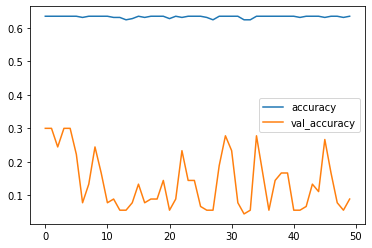

In [140]:
#let's look at our accuracy
plt.plot(historym1.history['acc'], label='accuracy')
plt.plot(historym1.history['val_acc'], label = 'val_accuracy')
plt.legend();

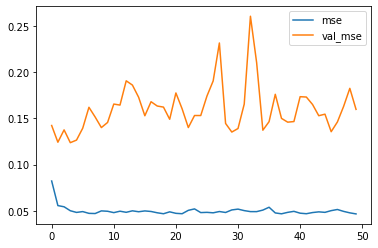

In [141]:
#let's look at our mse
plt.plot(historym1.history['mse'], label='mse')
plt.plot(historym1.history['val_mse'], label='val_mse')
plt.legend();

In [142]:
#I need to set up a null/baseline model to compare to
mean_y_train_array = np.full_like(y_train, y_train.mean())
mean_squared_error(y_train, mean_y_train_array, squared=False)

0.24662795519027217

In [143]:
mean_y_test_array = np.full_like(y_test, y_test.mean())
mean_squared_error(y_test, mean_y_test_array, squared=False)

0.3379607320070323

I think I have a model that beat the nulls! The accuracy isn't great, but the rmse values look really good! What if I make my model a little simpler? How does that do?

In [146]:
#I'm going to use one less GRU layer and then drop the epochs down to 30
modelm2 = Sequential()
modelm2.add(GRU(10, input_shape = (7,1), return_sequences=True))
modelm2.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm2.add(Dense(20, activation = 'relu'))
modelm2.add(Dense(1))

modelm2.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym2 = modelm2.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

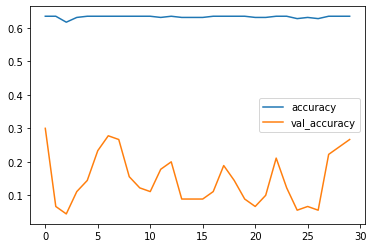

In [147]:
#let's look at our accuracy
plt.plot(historym2.history['acc'], label='accuracy')
plt.plot(historym2.history['val_acc'], label = 'val_accuracy')
plt.legend();

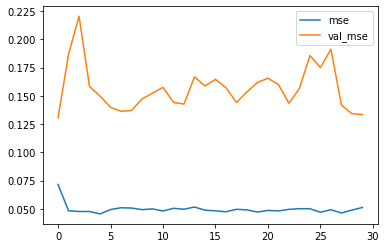

In [149]:
#let's look at our mse
plt.plot(historym2.history['mse'], label='mse')
plt.plot(historym2.history['val_mse'], label='val_mse')
plt.legend();

It looks like this simpler model performed more/less the same.

Now I'd like to try modelling the volume_per_day feature with the same one from above and see how that performs.

In [150]:
#define my X and y 
X = mega_df_weekly[['volume_per_day','avg_volh2o_per_ft']]
y = mega_df_weekly['Daily_Avg']

In [151]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [152]:
#now need to scale the data
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [153]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [154]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 2)

In [155]:
#I'm going to use multiple GRUs
modelm3 = Sequential()
modelm3.add(GRU(10, input_shape = (7,2), return_sequences=True))
modelm3.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm3.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm3.add(Dense(20, activation = 'relu'))
modelm3.add(Dense(1))

modelm3.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym3 = modelm3.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

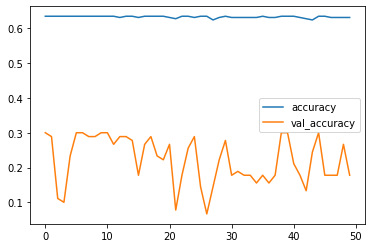

In [156]:
#let's look at our accuracy
plt.plot(historym3.history['acc'], label='accuracy')
plt.plot(historym3.history['val_acc'], label = 'val_accuracy')
plt.legend();

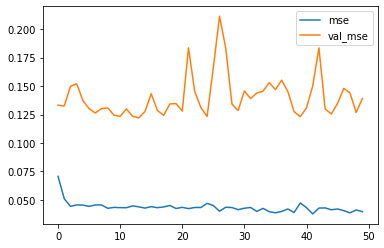

In [157]:
#let's look at our mse
plt.plot(historym3.history['mse'], label='mse')
plt.plot(historym3.history['val_mse'], label='val_mse')
plt.legend();

Recall that our null train rmse was 0.25 and null test rmse was 0.34 (both using the mean), so again, this model beat the null models.

Now I'd like to add in the fracs_per_day data with the other features and see how that does.

In [159]:
#define my X and y 
X = mega_df_weekly[['fracs_per_day','volume_per_day','avg_volh2o_per_ft']]
y = mega_df_weekly['Daily_Avg']

In [160]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [161]:
#now need to scale the data
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [162]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [163]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 3)

In [164]:
#I'm going to use multiple GRUs like before, but I want to try more epochs
modelm4 = Sequential()
modelm4.add(GRU(10, input_shape = (7,3), return_sequences=True))
modelm4.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm4.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm4.add(Dense(20, activation = 'relu'))
modelm4.add(Dense(1))

modelm4.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym4 = modelm4.fit(train_sequences, validation_data=test_sequences, epochs=60, verbose=0)

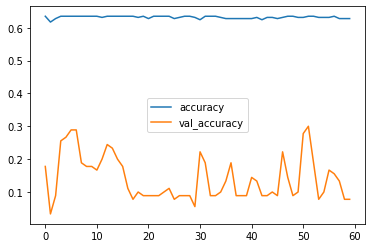

In [165]:
#let's look at our accuracy
plt.plot(historym4.history['acc'], label='accuracy')
plt.plot(historym4.history['val_acc'], label = 'val_accuracy')
plt.legend();

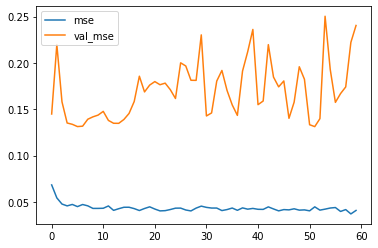

In [166]:
#let's look at our mse
plt.plot(historym4.history['mse'], label='mse')
plt.plot(historym4.history['val_mse'], label='val_mse')
plt.legend();

I think this model actually got down to a lower val rmse (down to ~0.15), which is the best yet. The extra epochs didn't really help though.

Now I want to try adding in the rig count feature and see how that affects the model.

In [167]:
#define my X and y 
X = mega_df_weekly[['fracs_per_day','volume_per_day','avg_volh2o_per_ft', 'Rig_Count']]
y = mega_df_weekly['Daily_Avg']

In [168]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [169]:
#now need to scale the data
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [170]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [171]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 4)

In [175]:
#I'm going to use multiple GRUs like before
modelm5 = Sequential()
modelm5.add(GRU(10, input_shape = (7,4), return_sequences=True))
modelm5.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm5.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm5.add(Dense(20, activation = 'relu'))
modelm5.add(Dense(1))

modelm5.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym5 = modelm5.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

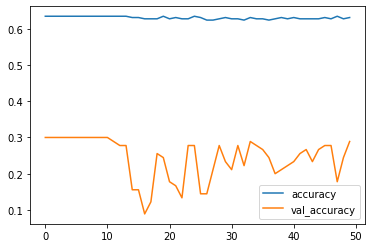

In [176]:
#let's look at our accuracy
plt.plot(historym5.history['acc'], label='accuracy')
plt.plot(historym5.history['val_acc'], label = 'val_accuracy')
plt.legend();

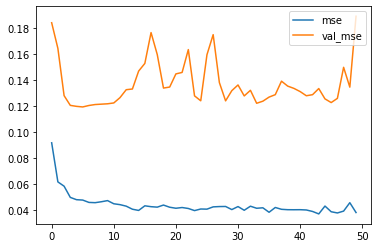

In [177]:
#let's look at our mse
plt.plot(historym5.history['mse'], label='mse')
plt.plot(historym5.history['val_mse'], label='val_mse')
plt.legend();

Wow, that gave me some different results, that actually improved my model a little bit! And it seems like the first 10 epochs were the best, then deviated after that. Our train and test rmse values improved a bit. 

Since we seem to be improving wtih each feature, I'm going to add the last two in there, which are the WTI and Brent Spot Prices. We'll see how that goes.

In [178]:
#define my X and y 
X = mega_df_weekly[['fracs_per_day','volume_per_day','avg_volh2o_per_ft', 'Rig_Count', 'WTI_Spot_Price', 'Brent_Spot_Price']]
y = mega_df_weekly['Daily_Avg']

In [179]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [180]:
#now need to scale the data
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [181]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [182]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 6)

In [183]:
#I'm going to use multiple GRUs like before, but I want to try more epochs
modelm6 = Sequential()
modelm6.add(GRU(10, input_shape = (7,6), return_sequences=True))
modelm6.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm6.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm6.add(Dense(20, activation = 'relu'))
modelm6.add(Dense(1))

modelm6.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym6 = modelm6.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

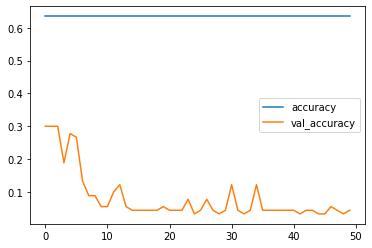

In [184]:
#let's look at our accuracy
plt.plot(historym6.history['acc'], label='accuracy')
plt.plot(historym6.history['val_acc'], label = 'val_accuracy')
plt.legend();

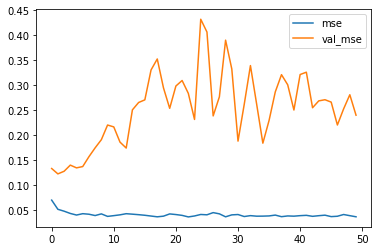

In [185]:
#let's look at our mse
plt.plot(historym6.history['mse'], label='mse')
plt.plot(historym6.history['val_mse'], label='val_mse')
plt.legend();

Well that model didn't do nearly as well! I'm going to try again, with just WTI price and see what that does.

In [186]:
#define my X and y 
X = mega_df_weekly[['fracs_per_day','volume_per_day','avg_volh2o_per_ft', 'Rig_Count', 'WTI_Spot_Price']]
y = mega_df_weekly['Daily_Avg']

In [187]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [188]:
#now need to scale the data
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [189]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [190]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 5)

In [191]:
#I'm going to use multiple GRUs like before, but I want to try more epochs
modelm7 = Sequential()
modelm7.add(GRU(10, input_shape = (7,5), return_sequences=True))
modelm7.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm7.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm7.add(Dense(20, activation = 'relu'))
modelm7.add(Dense(1))

modelm7.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym7 = modelm7.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

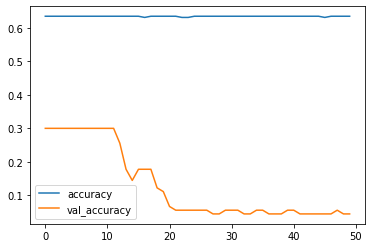

In [192]:
#let's look at our accuracy
plt.plot(historym7.history['acc'], label='accuracy')
plt.plot(historym7.history['val_acc'], label = 'val_accuracy')
plt.legend();

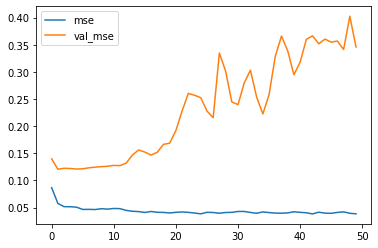

In [193]:
#let's look at our mse
plt.plot(historym7.history['mse'], label='mse')
plt.plot(historym7.history['val_mse'], label='val_mse')
plt.legend();

Now I'd like to try using a Conv1D layer and see if that improves my model at all.

In [211]:
#I'm going to use multiple GRUs like before, but I want to try Conv1D
modelm8 = Sequential()
modelm8.add(GRU(10, input_shape = (7,5), return_sequences=True))
modelm8.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm8.add(GRU(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
#Conv1D: 64- #nodes, #7 = filter size 7 time steps
modelm8.add(Conv1D(64, 7, activation = 'relu'))
#MaxPooling: 4 is size for pooling
modelm8.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
modelm8.add(Dense(20, activation = 'relu'))
modelm8.add(Dense(1))

modelm8.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym8 = modelm8.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

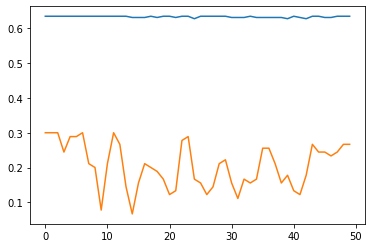

In [212]:
#let's look at our accuracy
plt.plot(historym8.history['acc'], label='accuracy')
plt.plot(historym8.history['val_acc'], label = 'val_accuracy')

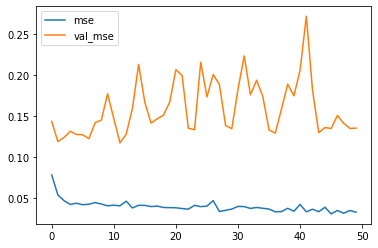

In [213]:
#let's look at our loss/mse
plt.plot(historym8.history['mse'], label='mse')
plt.plot(historym8.history['val_mse'], label='val_mse')
plt.legend();

Well I think can conclude that my best models so far are these last few. The rmse's are the lowest I've seen with the RNN. I think this is a combination of using all of my data (a much bigger time range than before) and using the best target, Daily Average Magnitude. From this last bit of modelling, I've also found that the most important features to use for predicting are Total Volume injected/day, Avg Volume of water injected/ft of lateral, the # of fracs going on per day, and the WTI Spot Price (a key indicator of activity level). 